## Real Stock Portfolio Optimization (Fractional VQE Client)

This notebook is an **example client** of the package’s fractional VQE workflow, using **real market data**.

### Pipeline

1. Download adjusted prices for a set of tickers (Yahoo Finance via `yfinance`).
2. Compute annualized expected returns $ \mu $ and covariance $ \Sigma $.
3. Run the package fractional VQE loop:

$$
\min_{w \in \Delta}\; -\mu^\top w + \lambda\, w^\top \Sigma w,
\qquad
\Delta=\{w \ge 0,\ \sum_i w_i=1\}.
$$

The package maps circuit expectations $z_i=\langle Z_i\rangle$ to scores $s_i=(1-z_i)/2$ and normalizes
$w_i=s_i/\sum_j s_j$, so weights are valid **by construction** (no penalty tuning).

### Notes

- Results depend on the data window, return convention (log vs simple), and covariance estimator.
- This example uses exact expectations (`shots=None`) for stable training; evaluate with finite shots for a deployment-like regime.

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np

from vqe_portfolio import get_stock_data, run_fractional_vqe
from vqe_portfolio.plotting import bar_allocations, plot_trace, savefig
from vqe_portfolio.types import FractionalVQEConfig
from vqe_portfolio.utils import resolve_notebook_outdir, set_global_seed

# Reproducibility
SEED = 0
set_global_seed(SEED)

OUTDIR = resolve_notebook_outdir()

## Data configuration

In [2]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN"]
start = "2024-01-01"
end = "2025-01-01"

# Estimation options
use_log = True
shrink = "lw"      # None or "lw"
scale = "none"     # "none", "trace", "max" (leave "none" for natural units)

mu_s, Sigma_df, prices = get_stock_data(
    tickers,
    start=start,
    end=end,
    auto_adjust=True,
    use_log=use_log,
    shrink=shrink,
    scale=scale,
)

# Convert to numpy arrays (ordered by tickers)
mu = np.array(mu_s.loc[tickers].values, dtype=float)
Sigma = np.array(Sigma_df.loc[tickers, tickers].values, dtype=float)

n_assets = len(tickers)

print("Tickers:", tickers)
print("Annualized mu:")
for t, m in zip(tickers, mu):
    print(f"  {t}: {float(m): .6f}")
print("\nSigma (annualized) shape:", Sigma.shape)
print("Prices rows:", prices.shape[0])

Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
Annualized mu:
  AAPL:  0.294857
  MSFT:  0.131252
  GOOGL:  0.308668
  AMZN:  0.368969

Sigma (annualized) shape: (4, 4)
Prices rows: 261


## Run Fractional VQE

In [3]:
LAM = 5.0  # risk aversion parameter

cfg = FractionalVQEConfig(
    steps=100,
    stepsize=0.25,
    log_every=10,
    shots=None,  # None -> exact expectations
    lam=LAM,
    seed=SEED,
    device="default.qubit",
)

res = run_fractional_vqe(mu, Sigma, cfg)

w_opt = np.array(res.weights, dtype=float)
w_opt = w_opt / (w_opt.sum() + 1e-12)

print("\nOptimized weights:")
for t, w in zip(tickers, w_opt):
    print(f"{t}: {float(w)*100:.2f}%")

# Metrics (in natural units)
port_ret = float(mu @ w_opt)
port_var = float(w_opt @ Sigma @ w_opt)
port_risk = float(np.sqrt(max(port_var, 0.0)))

print(f"\nPortfolio return: {port_ret:.6f}")
print(f"Portfolio risk  : {port_risk:.6f}")


Optimized weights:
AAPL: 49.96%
MSFT: 0.00%
GOOGL: 15.86%
AMZN: 34.19%

Portfolio return: 0.322382
Portfolio risk  : 0.192347


## Convergence plot

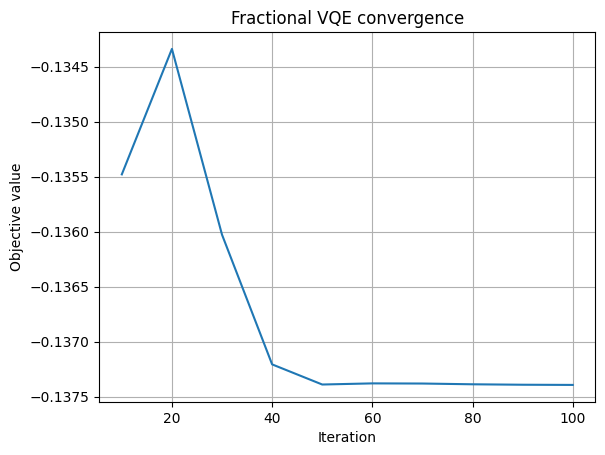

In [4]:
plot_trace(
    res.cost_trace.steps,
    res.cost_trace.values,
    xlabel="Iteration",
    ylabel="Objective value",
    title="Fractional VQE convergence",
    outpath=OUTDIR / "Fractional_VQE_Convergence_Example.png",
)
plt.show()

## Allocation plots

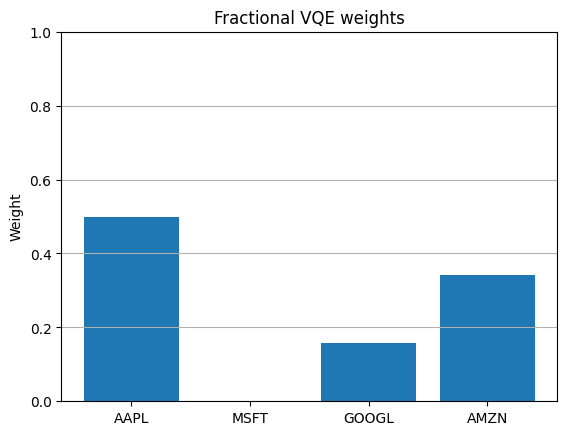

In [5]:
bar_allocations(
    labels=tickers,
    values=w_opt,
    ylabel="Weight",
    title="Fractional VQE weights",
    ylim=(0, 1),
    outpath=OUTDIR / "Fractional_VQE_Probabilities_Example.png",
)
plt.show()

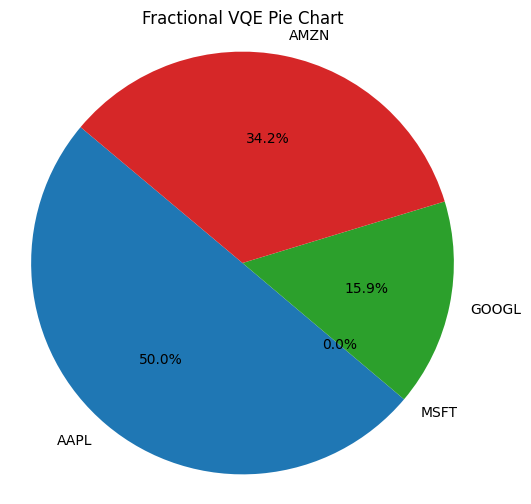

In [6]:
plt.figure(figsize=(6, 6))
plt.pie(w_opt, labels=tickers, autopct="%1.1f%%", startangle=140)
plt.title("Fractional VQE Pie Chart")
plt.axis("equal")
savefig(OUTDIR / "Fractional_VQE_Pie_Example.png", dpi=300)
plt.show()